In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import when
from pyspark.ml.feature import StandardScaler, VectorAssembler
from matplotlib import pyplot as plt
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
spark = SparkSession.builder.getOrCreate()

# Read CSV File
df_train = spark.read.option("inferSchema", "true").csv("ObesityDataSet_raw_and_data_sinthetic.csv", header = True)

# Selecting important features
df_train = df_train.select("Gender", "Age", "Height", "Weight", "family_history_with_overweight", "FAVC", "FCVC", "NCP",
                           "CAEC", "SMOKE", "CH2O", "SCC", "FAF", "TUE", "CALC", "MTRANS", "NObeyesdad")

# Data pre-processing
# - Menghilangkan Null values
df_train = df_train.na.drop()


# Data Transformation
# - Transforming data type from Categorical to Numerical

df_train = df_train.withColumn("Gender",
                               when(df_train["Gender"] == "Male", 1).
                               when(df_train["Gender"] == "Female", 0)
                               )

df_train = df_train.withColumn("family_history_with_overweight",
                               when(df_train["family_history_with_overweight"] == "yes", 1).
                               when(df_train["family_history_with_overweight"] == "no", 0)
                               )

df_train = df_train.withColumn("FAVC",
                               when(df_train["FAVC"] == "yes", 1).
                               when(df_train["FAVC"] == "no", 0)
                               )

df_train = df_train.withColumn("CAEC",
                               when(df_train["CAEC"] == "no", 1).
                               when(df_train["CAEC"] == "Sometimes" , 2).
                               when(df_train["CAEC"] == "Frequently", 3).
                               when(df_train["CAEC"] == "Always" , 4)
                               )

df_train = df_train.withColumn("SMOKE",
                               when(df_train["SMOKE"] == "yes", 1).
                               when(df_train["SMOKE"] == "no", 0)
                               )

df_train = df_train.withColumn("SCC",
                               when(df_train["SCC"] == "yes", 1).
                               when(df_train["SCC"] == "no", 0)
                               )

df_train = df_train.withColumn("CALC",
                               when(df_train["CALC"] == "no", 1).
                               when(df_train["CALC"] == "Sometimes" , 2).
                               when(df_train["CALC"] == "Frequently", 3).
                               when(df_train["CALC"] == "Always" , 4)
                               )

df_train = df_train.withColumn("MTRANS",
                               when(df_train["MTRANS"] == "Walking", 1).
                               when(df_train["MTRANS"] == "Public_Transportation", 2).
                               when(df_train["MTRANS"] == "Motorbike", 3).
                               when(df_train["MTRANS"] == "Automobile", 4)
                               )

df_train = df_train.withColumn("NObeyesdad",
                               when(df_train["NObeyesdad"] == "Insufficient_Weight", 1).
                               when(df_train["NObeyesdad"] == "Normal_Weight", 2).
                               when(df_train["NObeyesdad"] == "Overweight_Level_I", 3).
                               when(df_train["NObeyesdad"] == "Overweight_Level_II", 4).
                               when(df_train["NObeyesdad"] == "Obesity_Type_I", 5).
                               when(df_train["NObeyesdad"] == "Obesity_Type_II", 6).
                               when(df_train["NObeyesdad"] == "Obesity_Type_III", 7)
                               )



cols = df_train.columns
cols.remove("NObeyesdad")

df_train = VectorAssembler(inputCols = cols, outputCol = "features", handleInvalid="skip").transform(df_train)

scaler = StandardScaler(inputCol = "features", outputCol = "scaledFeatures")
df_train = scaler.fit(df_train).transform(df_train)

df_train.show(5)
# data splitting
training_data, testing_data = df_train.randomSplit([0.7, 0.3], seed=7)

# Logistic Regression
model = LogisticRegression(featuresCol ="scaledFeatures", labelCol="NObeyesdad", maxIter = 100).fit(training_data)

# Prediction
prediction = model.transform(testing_data)
prediction.select("scaledFeatures", "NObeyesdad", "Prediction").show(5)

# Evaluation

evaluator = MulticlassClassificationEvaluator(labelCol = "NObeyesdad", predictionCol = "prediction", metricName = "accuracy")
accuracy = evaluator.evaluate(prediction)
print(f"Accuracy: {accuracy * 100:0.2f}%")


+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+--------------------+--------------------+
|Gender| Age|Height|Weight|family_history_with_overweight|FAVC|FCVC|NCP|CAEC|SMOKE|CH2O|SCC|FAF|TUE|CALC|MTRANS|NObeyesdad|            features|      scaledFeatures|
+------+----+------+------+------------------------------+----+----+---+----+-----+----+---+---+---+----+------+----------+--------------------+--------------------+
|     0|21.0|  1.62|  64.0|                             1|   0| 2.0|3.0|   2|    0| 2.0|  0|0.0|1.0|   1|     2|         2|[0.0,21.0,1.62,64...|[0.0,3.3118608787...|
|     0|21.0|  1.52|  56.0|                             1|   0| 3.0|3.0|   2|    1| 3.0|  1|3.0|0.0|   2|     2|         2|[0.0,21.0,1.52,56...|[0.0,3.3118608787...|
|     1|23.0|   1.8|  77.0|                             1|   0| 2.0|3.0|   2|    0| 2.0|  0|2.0|1.0|   3|     2|         2|[1.0,23.0,1.8,77....|[1.99959783526519...|
|   

Text(0.5, 1.0, 'Age Distribution')

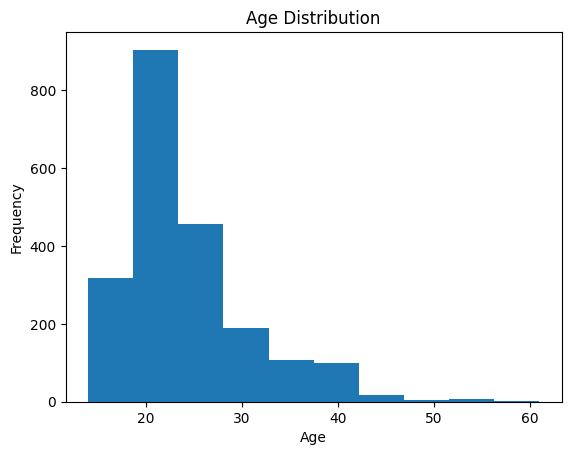

In [3]:
df_plot = df_train.toPandas()

plt.hist(df_plot["Age"], bins=10)
plt.xlabel("Age")
plt.ylabel("Frequency")
plt.title("Age Distribution")

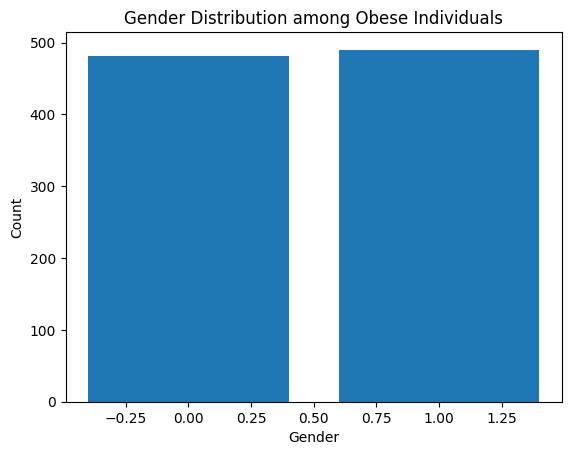

In [4]:
df_plot = df_train.toPandas()

# Filter the DataFrame for obese individuals
df_obese = df_plot[df_plot["NObeyesdad"] >= 5]

# Get the count of each gender
gender_count = df_obese["Gender"].value_counts()

# Plot the bar chart
plt.bar(gender_count.index, gender_count.values)
plt.xlabel('Gender')
plt.ylabel('Count')
plt.title('Gender Distribution among Obese Individuals')
plt.show()


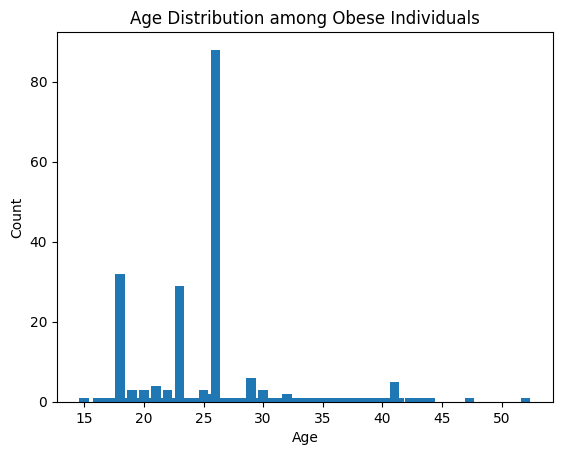

In [5]:
# Filter the DataFrame for obese individuals
df_obese = df_plot[df_plot["NObeyesdad"] >= 5]

# Get the count of each gender
gender_count = df_obese["Age"].value_counts()

# Plot the bar chart
plt.bar(gender_count.index, gender_count.values)
plt.xlabel('Age')
plt.ylabel('Count')
plt.title('Age Distribution among Obese Individuals')
plt.show()


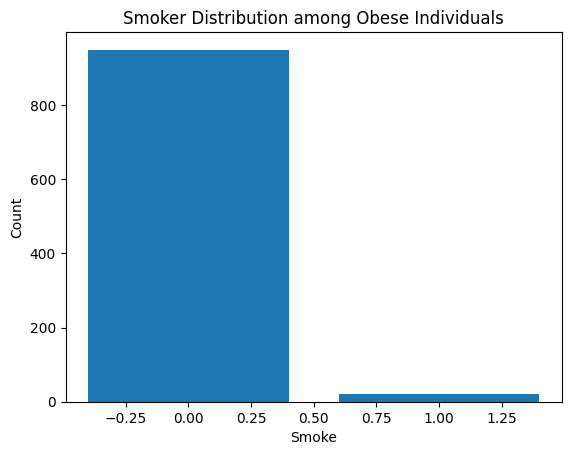

In [6]:
# Filter the DataFrame for obese individuals
df_obese = df_plot[df_plot["NObeyesdad"] >= 5]

# Get the count of each gender
gender_count = df_obese["SMOKE"].value_counts()

# Plot the bar chart
plt.bar(gender_count.index, gender_count.values)
plt.xlabel('Smoke')
plt.ylabel('Count')
plt.title('Smoker Distribution among Obese Individuals')
plt.show()


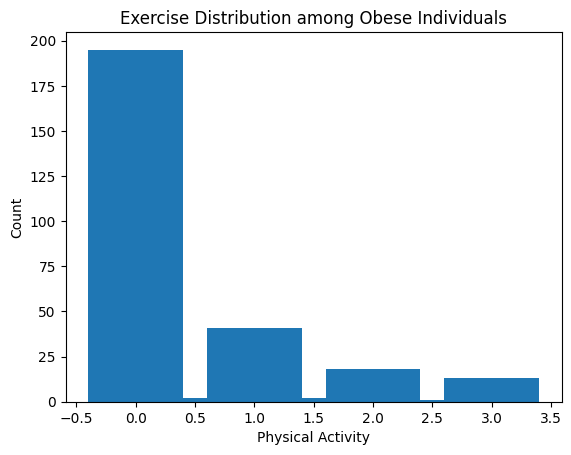

In [7]:
# Filter the DataFrame for obese individuals
df_obese = df_plot[df_plot["NObeyesdad"] >= 5]

# Get the count of each gender
gender_count = df_obese["FAF"].value_counts()

# Plot the bar chart
plt.bar(gender_count.index, gender_count.values)
plt.xlabel('Physical Activity')
plt.ylabel('Count')
plt.title('Exercise Distribution among Obese Individuals')
plt.show()
